In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time
import vegas
import pickle
from scipy import interpolate
from tqdm import tqdm_notebook as tqdm#from tqdm import tqdm
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

#import functions from file in path 
sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/functions')
from functions2 import integrate_vdist, integrate_imf
from data_loading import load_masses, load_models
from interpolation import M_V_T_interp, MVT_interp_setup, v_over_vcrit_interp, interp_vcrit_min

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #

# set up velocity distribution # 

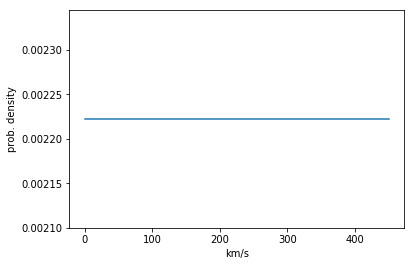

In [26]:
v_max_val=450.0
v_dist=np.poly1d(1.0/v_max_val)

vs=np.linspace(0,v_max_val, 100)
plt.plot(vs, v_dist(vs))

plt.xlabel('km/s')
plt.ylabel('prob. density')
plt.show()

# set up IMF # 

In [7]:
#check that total CDF between mass limits is 1. If not eta0 value needs to be tweaked! 

alpha=2.3

lower= 3
upper =25
eta0=1 / integrate_imf(lower,upper, alpha,1)

print "integral of IMF between ", lower,'and', upper, ',eta0 = ', eta0, ":"
print integrate_imf(lower , upper , alpha , eta0)

integral of IMF between  3 and 25 ,eta0 =  5.79034154251 :
1.0


In [13]:
#load data in 
data_files, mass_list= load_masses(data_dir, 25)

data_df=load_models(data_files)

#for each mass, find initial velocity of fastest rotator
vmax_dict={}
for m in mass_list:
    di=data_df[data_df.M == m ]
    vmax=np.unique(di['V']).max()
    #print di['V_init'][di['V']== vmax].iloc[0], m
    vmax_dict[m]=di['V_init'][di['V']== vmax].iloc[0]

#set up MVT interpolation
v_T_interp= MVT_interp_setup(data_df, mass_list)

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25.]
working on file 112 / 112

# find largest mass still on MS at any time t # 

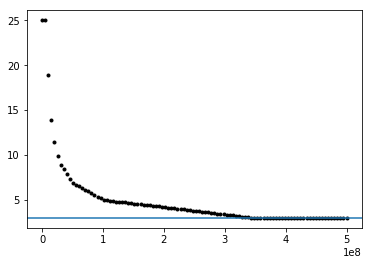

In [45]:
def M_max_calculator(t, v_maximum, largest_m):
    if t==0: 
        return largest_m
    mass_vals=pd.Series(np.linspace(mass_list.min(), largest_m, 1+1e3 ))
    frac_lifetimes= pd.Series(map(lambda r: t/M_V_T_interp(r, v_maximum, v_T_interp), mass_vals))

    T_df= pd.concat([frac_lifetimes, mass_vals], axis=1)

    #get index of mass with t/T closest to 1 
    #print (T_df[0]-1).abs().argmin()
    return T_df[1].iloc[(T_df[0]-1).abs().argmin()]

for t in tqdm(np.linspace(0,500e6, 1e2)):
    M=M_max_calculator(t, 400, max(mass_list))
    plt.plot(t, M, 'k.')
    
plt.axhline(3)
plt.show()


# find minimum velocity star of mass m needs to have to be on the MS at time t #

In [46]:
def V_min_calculator(t,m, v_maximum):
    
    #if non-rotating star is still MS, vmin is 0 
    
    if t/M_V_T_interp(m, 0, v_T_interp) <1 : 
        return 0 
    
    #if fastest rotating star is not MS, return nan
    if t/M_V_T_interp(m, v_maximum,v_T_interp) > 1 : 
        return np.nan
    
    
    v_vals=pd.Series(np.linspace(0,v_maximum,1+1e3))
    frac_lifetimes= pd.Series(map(lambda r: t/M_V_T_interp(m, r, v_T_interp), v_vals))
    
    T_df= pd.concat([frac_lifetimes, v_vals], axis=1)
    
    
    return T_df[1].iloc[(T_df[0]-1).abs().argmin()]

# find minimum velocity star needs to be on MS & critically rotating #

 # compute number of stars on MS & rotating critically as function of time #

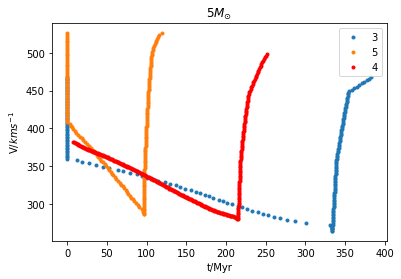

0.03604656171252638


In [76]:
v_critmin_boundary= pickle.load(open("../v-crit-min/v_critmin_boundary.pk", 'rb'))
def integrand_n(x):
        m_i=x[0]
        V_i=x[1]
 
        Vc_min_df= interp_vcrit_min(m_i, B_i, data_df,v_critmin_boundary, vmax_dict,v_T_interp )
        
        ik=(Vc_min_df['t']-t).abs().argmin()
        Vc_min= Vc_min_df['V_init'].iloc[ik] #,  res_df['t'].iloc[ik]
        
        
        i=integrate_vdist(Vc_min ,v_max_val, v_dist,v_max_val)/integrate_vdist(0 ,v_max_val, v_dist,v_max_val)
        
        i1=eta0 * m_i**-alpha
        #print 'Vc_min=', Vc_min, 'm=',np.round(m_i, 2), 't=', np.round(t/1e6,2), 'TMS=', np.round(T/1e6, 2)
        return i*i1
   
t=8e6 
B_i=0.7

print integrand_n([4,0])

STARTING


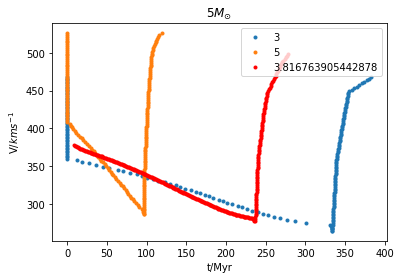

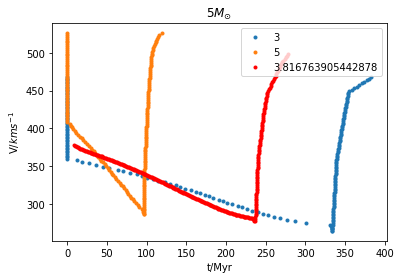

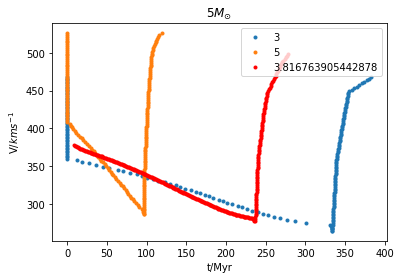

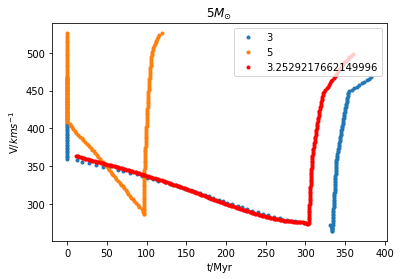

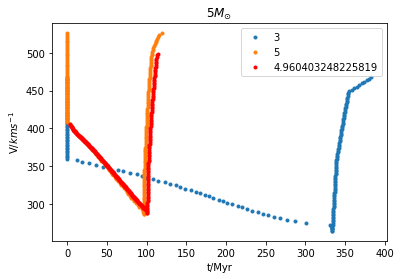

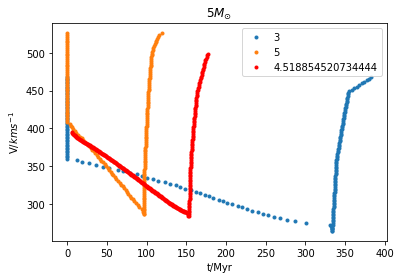

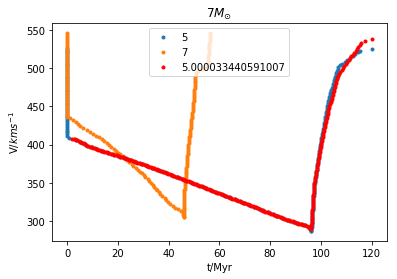

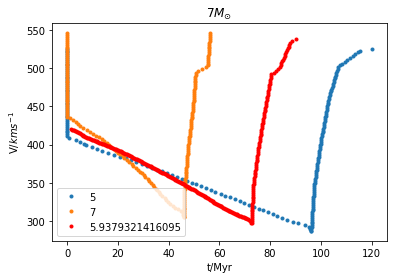

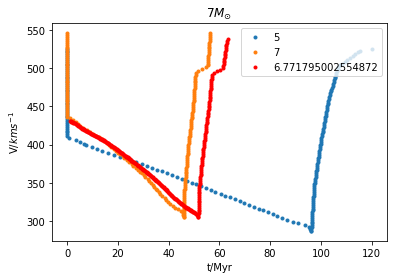

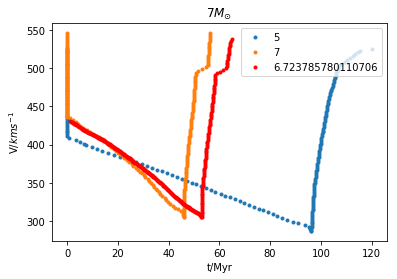

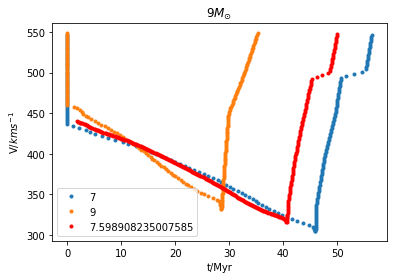

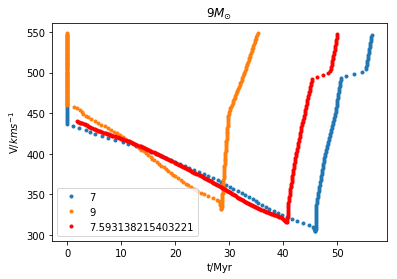

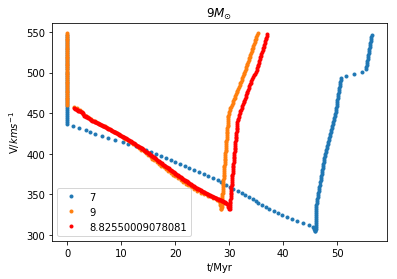

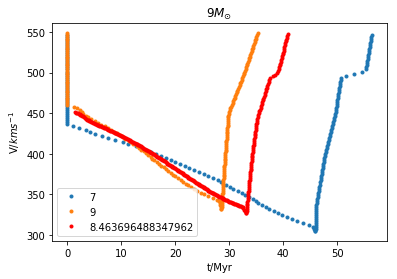

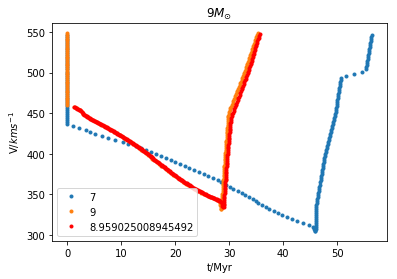

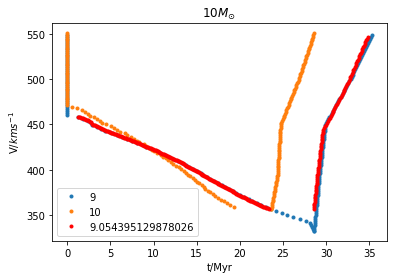

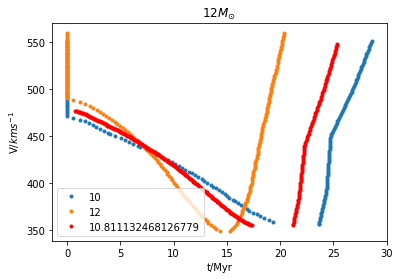

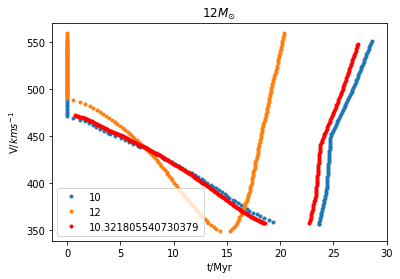

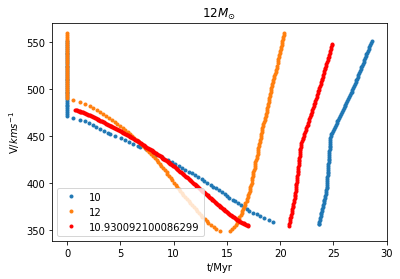

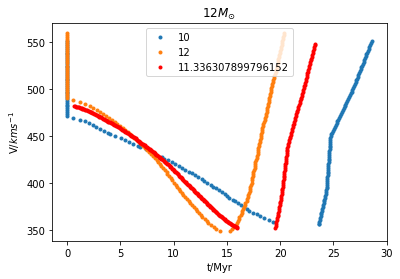

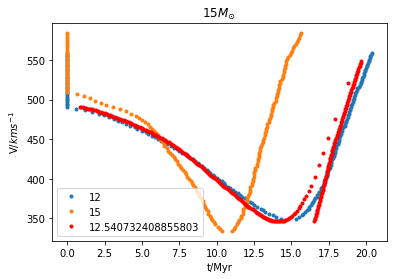

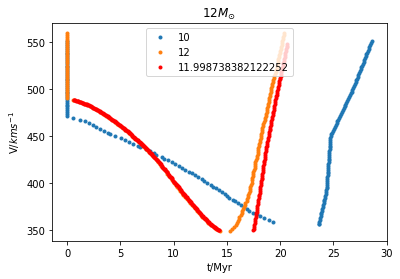

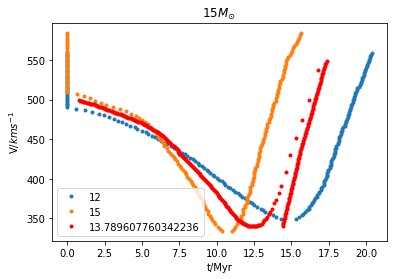

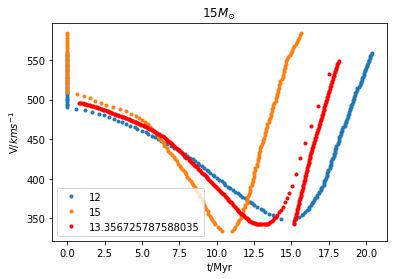

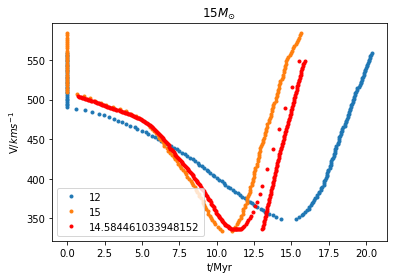

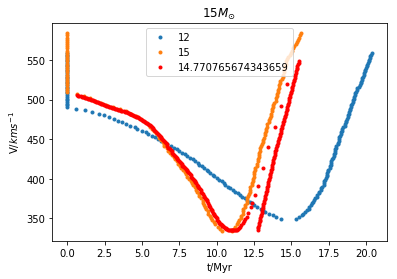

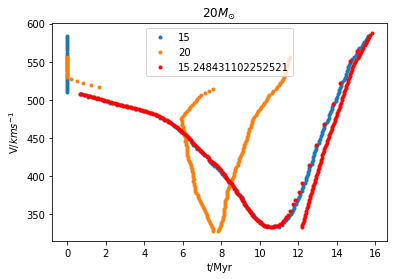

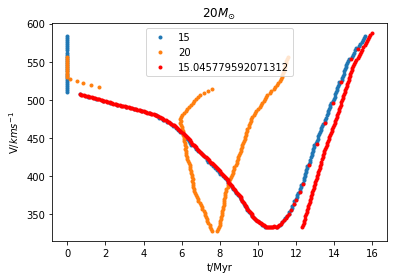

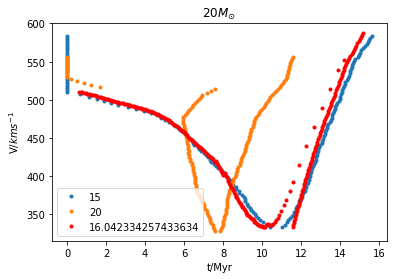

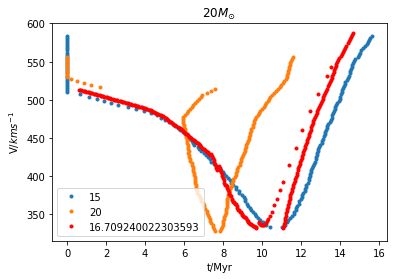

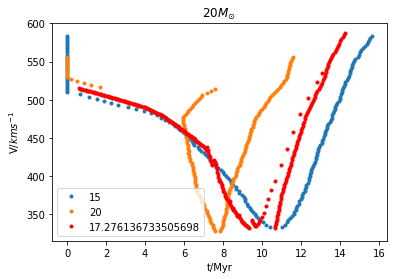

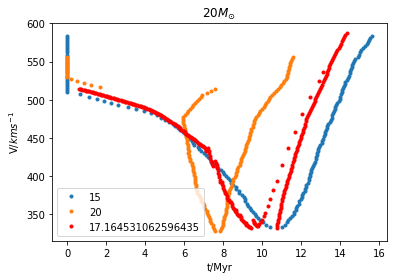

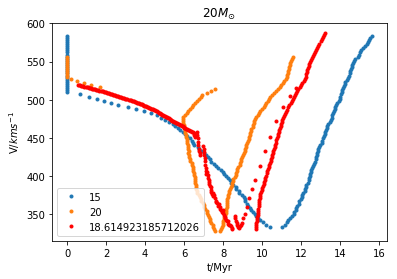

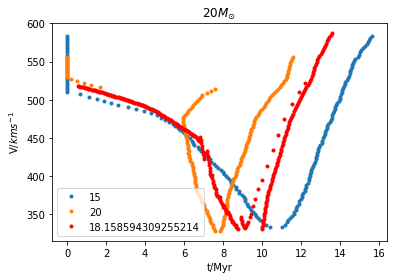

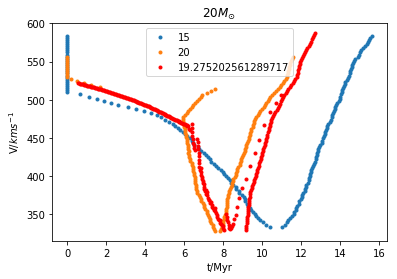

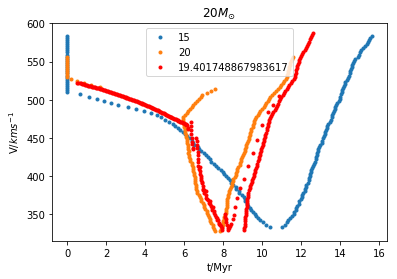

ValueError: A value in x_new is above the interpolation range.

In [79]:
print 'STARTING'
df_n=pd.DataFrame()
start_time=time.time()
for t in tqdm([8,10,15,20,25,30,35,40,45,50]):
    t=t*1e6
    M_max=M_max_calculator(t, v_max_val, max(mass_list))
    #M_min=0.7*M_max
    integ = vegas.Integrator([[3,M_max], [0, 1]])
    result_n = integ(integrand_n, nitn=2, neval=2e3)
    print result_n.summary()
    #print t/1e6,np.round(M_max,3), np.round(result_N.val,5)
    df_n=df_n.append(pd.DataFrame([[t,result_n.val]], columns=['t', 'f']))
    #df_N.to_pickle('./N_res-all.pk')
print '\ntime taken (mins)= ',   (time.time()- start_time)/60

print df_n

# compute number of stars on MS as function of time # 

In [58]:
def integrand_N(x):
        #print t
        m_i=x[0]
        V_i=x[1]
        
        V_min=  V_min_calculator(t,m_i,v_max_val)
        
        i=integrate_vdist(V_min ,v_max_val, v_dist,v_max_val)/integrate_vdist(0 ,v_max_val, v_dist,v_max_val)
        
        i1=eta0 * m_i**-alpha
        #print 'integrands',i, i1
        #print 'V_min=', np.round(V_min,1),'i',np.round(i,3), 'm=',np.round(m_i, 2),  't=', np.round(t/1e6,2)
        return i*i1
    
t=8e6 
print integrand_N([4,0])

0.23876254598198135


In [60]:
print 'STARTING'
df_N=pd.DataFrame()
start_time=time.time()
for t in tqdm([8,10,15,20,25,30,35,40,45,50]):
    t=t*1e6
    M_max=M_max_calculator(t, v_max_val, max(mass_list))
    #M_min=0.7*M_max
    integ = vegas.Integrator([[3,M_max], [0, 1]])
    result_N = integ(integrand_N, nitn=2, neval=2e3)
    print result_N.summary()
    #print t/1e6,np.round(M_max,3), np.round(result_N.val,5)
    df_N=df_N.append(pd.DataFrame([[t,result_N.val]], columns=['t', 'f']))
    #df_N.to_pickle('./N_res-all.pk')
print '\ntime taken (mins)= ',   (time.time()- start_time)/60

print df_N

STARTING


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.000(12)       1.000(12)           0.00     1.00
  2   nan +- nan      nan +- nan           nan     1.00

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.9702(76)      0.9702(76)          0.00     1.00
  2   0.9654(34)      0.9662(31)          0.34     0.56

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   nan +- nan      nan +- nan          0.00     1.00
  2   0.9190(42)      nan +- nan           nan     1.00

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.8680(29)      0.8680(29)          0.00     1.00
  2   0.8697(21)      0.8691(17)          0.22     0.64

itn   integral        wgt average     chi2/dof        Q
--------------------------------------------

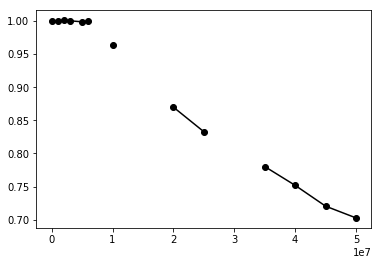

In [50]:
x=df_N.t
y=df_N.f
plt.plot(x,y, 'ko-')
plt.show()